In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
%matplotlib inline

In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25

In [3]:
contract = contract.loc['20180202':]

In [4]:
time_int = 60 # interval in minutes to be used to define volume candle
periods = 20
ema_fast = 120 # number of periods for moving average filter
sl_atr = 200 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
#commission = 2.1 # level of commision per transaction in dollars
commission = 0
bankroll = 15000
threshold = 1.0

In [5]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [6]:
#avg_vol = 14913

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [8]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                    'close': vol_candles.close, 
                    'atr': vol_candles.atr})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
#data.set_index('date', inplace=True)
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()
data['breakout_norm_mean'] = data['breakout_norm'].ewm(span=periods).mean()
data['long'] = (data.breakout_norm_mean > threshold) * 1
data['short'] = (data.breakout_norm_mean < -threshold) * -1
data['signal'] = data['long'] + data['short']

In [9]:
data['ema'] = data.close.ewm(span=ema_fast).mean()
rows_to_drop = 3 * periods
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [10]:
data['filter'] = np.sign(data['close'] - data['ema'])
#data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
data['filtered_signal'] = data['signal']

In [11]:
# while in position maintain open price and transaction direction
data['positions'] = 0
# flag to execute transaction at next data point
data['mark'] = False
# note the reason for transaction at next data point
data['reason'] = ''
# record commission paid
data['commission'] = 0
# record transaction price
data['price'] = 0
# entry price for stop loss calculation
data['entry'] = 0

for item in data.itertuples(): 
    # first row doesn't have to check if we have positions or execute transactions
    if not item.Index == 0:
        # starting position is the same as previous day position
        data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'positions'] 
        data.loc[item.Index, 'entry'] = data.loc[(item.Index - 1), 'entry'] 
        # execute transactions
        if data.loc[(item.Index -  1), 'mark']:
            # close position
            if data.loc[item.Index, 'positions']:
                data.loc[item.Index, 'positions'] = 0
                data.loc[item.Index, 'entry'] = 0
                # record transaction price
                data.loc[item.Index, 'price'] = item.open * np.sign(data.loc[(item.Index - 1), 'entry']) * -1
            # open position
            else:
                data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'signal']
                data.loc[item.Index, 'entry'] = item.open * data.loc[(item.Index - 1), 'signal']
                # record transaction price
                data.loc[item.Index, 'price'] = item.open * data.loc[(item.Index -1), 'signal']
            # record commission paid
            data.loc[item.Index, 'commission'] = commission

    # check for close signal
    if data.loc[item.Index, 'positions'] != 0 and item.signal != data.loc[item.Index, 'positions']:
        data.loc[item.Index, 'mark'] = True
        data.loc[item.Index, 'reason'] = 'close'
    # check for stop-loss signal
    # long positions
    if data.loc[item.Index, 'positions'] > 0:
        if item.close <= (data.loc[item.Index, 'entry'] - (item.atr * sl_atr)):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
    # short positions
    if data.loc[item.Index, 'positions'] < 0:
        if item.close >= abs((data.loc[item.Index, 'entry'] - (item.atr * sl_atr))):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
    # check for entry signal
    if data.loc[item.Index, 'positions'] == 0:
        if item.filtered_signal != 0:
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'entry'
# close any open positions
if data[data.price != 0].price.count() % 2 != 0:
    data.loc[data.index[-1], 'price'] = data.open.iloc[-1] * np.sign(data.entry.iloc[-1]) * -1
    data.loc[data.index[-1], 'entry'] = 0
data.set_index('date', inplace=True)

In [12]:
pnl = data[['open','positions', 'commission', 'mark', 'reason', 'price', 'entry']]
pnl['mark'] = pnl['mark'].shift(1)
pnl['reason'] = pnl['reason'].shift(1)

In [13]:
pnl = pnl[pnl.price != 0]
pnl['close'] = pnl.price.shift(-1)
pnl = pnl[pnl.reason == 'entry']
pnl['pnl'] = -(pnl.entry + pnl.close) * multiplier
pnl['net_pnl'] = pnl.pnl - 2 * pnl.commission
pnl['cum_pnl'] = pnl.pnl.cumsum()
pnl['net_cum_pnl'] = pnl.net_pnl.cumsum()
pnl['balance'] = bankroll + pnl.net_cum_pnl

In [14]:
pnl.pnl.sum()

19962.5

In [15]:
pnl.net_pnl.sum()

19962.5

In [16]:
# percentage of winning transactions
win_pct = pnl[pnl.pnl > 0].pnl.count() / (pnl.pnl.count())
win_pct

0.38095238095238093

In [17]:
# avg. win,  avg. lose, ratio
avg_win = pnl[pnl.pnl > 0].pnl.mean()
avg_lose = pnl[pnl.pnl <= 0].pnl.mean()
ratio = abs(avg_win / avg_lose)
avg_win, avg_lose, ratio

(1259.548611111111, -604.4871794871794, 2.0836647225167906)

In [18]:
# transaction EV
ev = win_pct * avg_win + (1 - win_pct) * avg_lose
ev

105.62169312169306

In [19]:
# number of positions
pnl.pnl.count()

189

In [20]:
pnl.pnl.count() * ev

19962.49999999999

In [21]:
pnl.pnl.min(), pnl.pnl.max(), round(abs(pnl.pnl.max() / pnl.pnl.min()), 1)

(-2250.0, 6975.0, 3.1)

In [22]:
daily = pnl.resample('B').last().fillna(method='ffill')
daily.loc[daily.index[0]-pd.Timedelta(days=1), 'balance'] = bankroll
daily.sort_index(inplace=True)
daily['return'] = daily.balance.pct_change().fillna(0)
daily = daily.iloc[1:]

In [23]:
data.commission.sum()

0

In [24]:
perf_stats(daily['return'])

Annual return           0.675885
Cumulative returns      1.330833
Annual volatility       0.598015
Sharpe ratio            1.130253
Calmar ratio            2.665542
Stability               0.617731
Max drawdown           -0.253564
Omega ratio             1.454624
Sortino ratio           2.712055
Skew                    5.523152
Kurtosis               58.252275
Tail ratio              1.751036
Daily value at risk    -0.072661
dtype: float64

In [25]:
days = daily['return'].count()
days

413

In [26]:
transactions = data[data.price != 0].price.count()
transactions

378

In [27]:
transactions / days

0.9152542372881356

In [28]:
days / transactions

1.0925925925925926

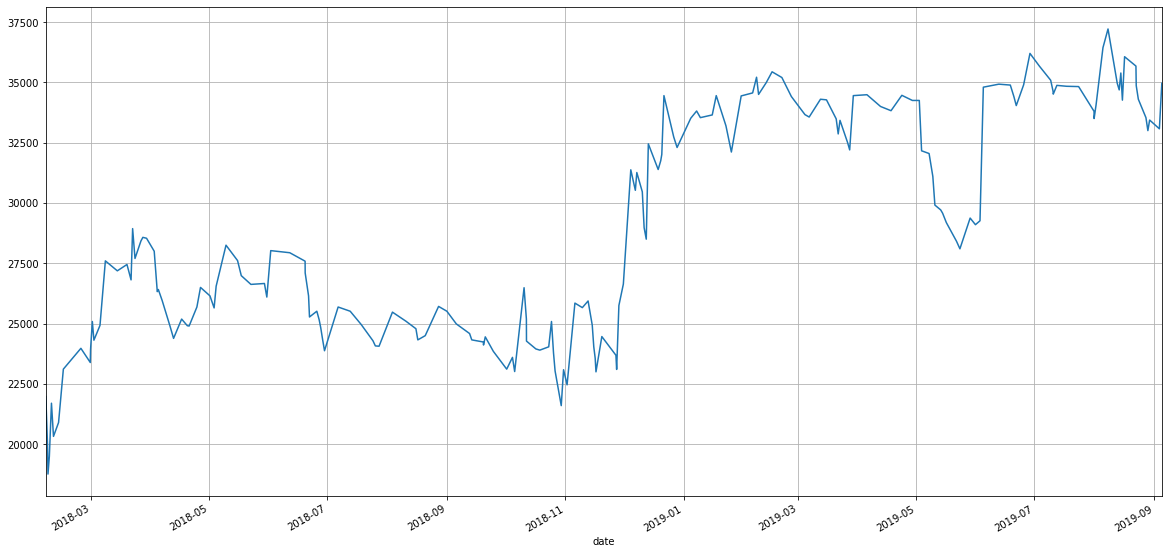

In [29]:
pnl.balance.plot(figsize=(20,10), grid=True);